In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Download and Unzip Dataset
# !wget -O AAF.zip "https://www.dropbox.com/s/a0lj1ddd54ns8qy/All-Age-Faces%20Dataset.zip?dl=1"
!unzip -q /content/drive/MyDrive/CV_PTIT/dataset_lora_olds2/All_Age_Faces_Dataset.zip -d /content/AAF/


/content/AAF/All-Age-Faces Dataset/original images/13022A69.jpg


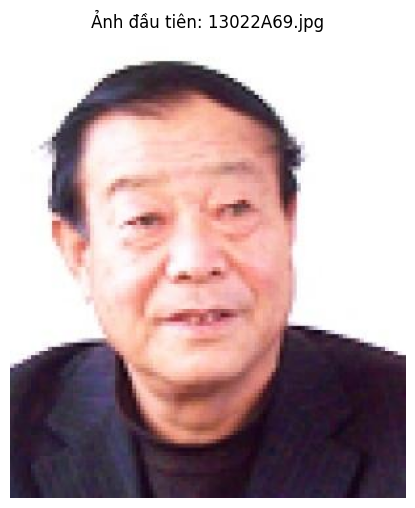

In [ ]:
# @title Check Img
import cv2
import matplotlib.pyplot as plt
import os

# Đường dẫn đến thư mục ảnh gốc
img_dir = '/content/AAF/All-Age-Faces Dataset/original images'

# Lấy danh sách file ảnh (và sắp xếp để lấy ảnh đầu tiên)
img_list = sorted(os.listdir(img_dir))

# Ảnh đầu tiên
first_img_name = img_list[13022]
img_path = os.path.join(img_dir, first_img_name)

# Đọc ảnh bằng OpenCV
img = cv2.imread(img_path)
print(img_path)
# Kiểm tra xem ảnh có đọc được không
if img is None:
    print(f"❌ Không đọc được ảnh: {img_path}")
else:
    # Chuyển BGR → RGB để hiển thị đúng màu
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Hiển thị ảnh
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.title(f"Ảnh đầu tiên: {first_img_name}")
    plt.axis('off')
    plt.show()


In [ ]:
# @title Make ages_caption json (DONE)
import json
import os
import re

# Đường dẫn dataset
IMG_DIR = "/content/AAF/All-Age-Faces Dataset/original images"
ANNOT_DIR = "/content/AAF/All-Age-Faces Dataset/image sets"

#Hàm chuyển tuổi thành bucket
def age_bucket(age: int):
    if age < 10: return "0s"
    elif age < 20: return "10s"
    elif age < 30: return "20s"
    elif age < 40: return "30s"
    elif age < 50: return "40s"
    elif age < 60: return "50s"
    elif age < 70: return "60s"
    elif age < 80: return "70s"
    elif age < 90: return "80s"
    else: return "90s"

#Hàm đọc annotation file
def process_annotation_file(txt_path):
    dataset = []
    with open(txt_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) != 2:
                continue

            img_name, gender = parts
            gender = int(gender)
            gender_str = "man" if gender == 1 else "woman"

            # 🔍 Trích tuổi từ tên file dạng 00000A02.jpg
            match = re.search(r"A(\d{2})", img_name)
            if not match:
                continue
            age = int(match.group(1))

            # 🔢 Bucket tuổi
            bucket = age_bucket(age)

            # 🧾 Caption dạng “a portrait photo of a man, age 60s”
            caption = f"a portrait photo of a {gender_str}, age {bucket}"

            # 🔗 Đường dẫn ảnh
            img_path = os.path.join(IMG_DIR, img_name)
            if os.path.exists(img_path):
                dataset.append({
                    "image": img_path,
                    "text": caption
                })

    return dataset

# 🧩 Gộp cả train và test
train_path = os.path.join(ANNOT_DIR, "train.txt")
test_path  = os.path.join(ANNOT_DIR, "val.txt")

dataset = []
if os.path.exists(train_path):
    dataset.extend(process_annotation_file(train_path))
if os.path.exists(test_path):
    dataset.extend(process_annotation_file(test_path))

# 💾 Xuất ra JSON
output_path = "/content/drive/MyDrive/CV_PTIT/dataset_lora_olds2/AAF_age_gender_caption_dataset.json"
with open(output_path, "w") as f:
    json.dump(dataset, f, indent=2)

print(f"✅ Đã tạo file: {output_path}")
print(f"Số ảnh: {len(dataset)}")
if dataset:
    print("🔹 Ví dụ caption:", dataset[0])



✅ Đã tạo file: /content/drive/MyDrive/CV_PTIT/dataset_lora_olds2/AAF_age_gender_caption_dataset.json
Số ảnh: 13322
🔹 Ví dụ caption: {'image': '/content/AAF/All-Age-Faces Dataset/original images/00000A02.jpg', 'text': 'a portrait photo of a woman, age 0s'}


In [ ]:
import json

json_path = "/content/drive/MyDrive/CV_PTIT/dataset_lora_olds2/AAF_age_gender_caption_dataset.json"

with open(json_path, "r") as f:
    data = json.load(f)

print(f"✅ Tổng số mẫu: {len(data)}")
print("🔹 Ví dụ:", data[0])


✅ Tổng số mẫu: 13322
🔹 Ví dụ: {'image': '/content/AAF/All-Age-Faces Dataset/original images/00000A02.jpg', 'text': 'a portrait photo of a woman, age 0s'}


In [ ]:
!pip install -U diffusers==0.30.0 transformers accelerate safetensors bitsandbytes xformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.35.2
    Uninstalling diffusers-0.35.2:
      Successfully uninstalled diffusers-0.35.2


In [ ]:
from accelerate.utils import write_basic_config
write_basic_config(mixed_precision='fp16')  # giúp Colab tiết kiệm VRAM


PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [ ]:
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers
!pip install -e .[torch]  # cài diffusers ở chế độ editable
!pip install accelerate transformers safetensors bitsandbytes xformers


Cloning into 'diffusers'...
remote: Enumerating objects: 109492, done.
remote: Counting objects: 100% (686/686), done.
remote: Compressing objects: 100% (292/292), done.
remote: Total 109492 (delta 555), reused 396 (delta 394), pack-reused 108806 (from 4)
Receiving objects: 100% (109492/109492), 84.42 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (81136/81136), done.
/content/diffusers
Obtaining file:///content/diffusers
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.36.0.dev0-0.editable-py3-none-any.whl size=11374 sha256=62b7c74fe6e6b0d3bc35efff47ddee2c78ea7aaac474dead1c0944cd6f74f568
  Stored in directory: /tmp/pip-ephem-wheel-cache-byu0rzp5/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Succes

In [ ]:
# @title Check Nội dung Age_lora json
import os
base = "/content/AAF_prepared"
count = sum(1 for f in os.listdir(base) if f.endswith(".jpg"))
samples = sorted([f for f in os.listdir(base) if f.endswith(".jpg")])[:5]
print(f"✅ Có {count} ảnh trong dataset, ví dụ:")
for f in samples:
    txt = f.replace(".jpg", ".txt")
    print(f"  - {f}  | caption: {open(os.path.join(base, txt)).read().strip()[:60]}")


✅ Có 13322 ảnh trong dataset, ví dụ:
  - 00000A02.jpg  | caption: a portrait photo of a woman, age 0s
  - 00001A02.jpg  | caption: a portrait photo of a woman, age 0s
  - 00002A02.jpg  | caption: a portrait photo of a woman, age 0s
  - 00003A02.jpg  | caption: a portrait photo of a woman, age 0s
  - 00004A02.jpg  | caption: a portrait photo of a woman, age 0s


In [ ]:
# @title Make age_lora_dataset cho đúng fomat của Diffusers==0.36.0.dev0
import json, os, shutil
from pathlib import Path

# Đường dẫn
json_path = "/content/drive/MyDrive/CV_PTIT/dataset_lora_olds2/AAF_age_gender_caption_dataset.json"
output_dir = Path("/content/AAF_LoRA_Dataset")
output_dir.mkdir(parents=True, exist_ok=True)

# Đọc file JSON gốc
with open(json_path, "r") as f:
    data = json.load(f)

# Tạo metadata.jsonl
meta_path = output_dir / "metadata.jsonl"
with open(meta_path, "w") as f:
    for item in data:
        src = Path(item["image"])
        dst = output_dir / src.name
        if not dst.exists():
            shutil.copy(src, dst)
        record = {"file_name": src.name, "text": item["text"]}
        f.write(json.dumps(record, ensure_ascii=False) + "\n")

print(f"✅ Dataset saved to: {output_dir}")
print(f"✅ metadata.jsonl contains {len(data)} records.")


✅ Dataset saved to: /content/AAF_LoRA_Dataset
✅ metadata.jsonl contains 13322 records.


In [ ]:
!rm -rf ~/.cache/huggingface


In [ ]:
 # @title Train Age LoRA - Stable Diffusion 1.5
!accelerate launch examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/content/AAF_LoRA_Dataset" \
  --output_dir="/content/drive/MyDrive/CV_PTIT/age_lora" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=8 \
  --learning_rate=1e-4 \
  --max_train_steps=12000 \
  --rank=8 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --caption_column="text" \
  --image_column="image" \
  --mixed_precision="fp16"\
  --resume_from_checkpoint="latest"


/usr/bin/python3: can't open file '/content/examples/text_to_image/train_text_to_image_lora.py': [Errno 2] No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/accelerate", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/accelerate/commands/accelerate_cli.py", line 50, in main
    args.func(args)
  File "/usr/local/lib/python3.12/dist-packages/accelerate/commands/launch.py", line 1235, in launch_command
    simple_launcher(args)
  File "/usr/local/lib/python3.12/dist-packages/accelerate/commands/launch.py", line 823, in simple_launcher
    raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
subprocess.CalledProcessError: Command '['/usr/bin/python3', 'examples/text_to_image/train_text_to_image_lora.py', '--pretrained_model_name_or_path=runwayml/stable-diffusion-v1-5', '--train_data_dir=/content/AAF_LoRA_Dataset', '--output_dir=/content/drive/MyDrive/CV_PTIT/age_lora', '-

In [ ]:
# @title Train Identity LoRA - Stable Diffusion 1.5
!accelerate launch examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/content/drive/MyDrive/CV_PTIT/identity_lora_dataset" \
  --output_dir="/content/drive/MyDrive/CV_PTIT/identity_lora_personChung" \
  --resolution=512 \
  --train_batch_size=1 \
  --learning_rate=1e-4 \
  --max_train_steps=4000 \
  --rank=4 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention\
  --caption_column="text" \
  --image_column="image" \
  --mixed_precision="fp16"


2025-10-24 14:07:13.919271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761314833.957905    6078 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761314833.969186    6078 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761314833.997546    6078 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761314833.997584    6078 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761314833.997593    6078 computation_placer.cc:177] computation placer alr

In [ ]:
# @title check mem of folder
!du -sh /content/drive/MyDrive/CV_PTIT/age_lora/logs


491K	/content/drive/MyDrive/CV_PTIT/age_lora/logs


In [ ]:
!pip install --force-reinstall diffusers==0.30.0

  Using cached diffusers-0.30.0-py3-none-any.whl.metadata (18 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 5.0 MB/s eta 0:00:00
Using cached diffusers-0.30.0-py3-none-any.whl (2.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.4/803.4 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.8/485.8 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 15.0 MB/s eta 0:00:00

In [ ]:
import diffusers
print(diffusers.__version__)


0.30.0


In [ ]:
# @title Test Age_ LoRA
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,     # ✅ Bỏ bộ lọc NSFW
).to("cuda")

pipe.load_lora_weights("/content/drive/MyDrive/CV_PTIT/age_lora")

image = pipe("a portrait photo of a man, age 10",
             num_inference_steps=25, guidance_scale=7.5).images[0]
image.save("test_man30.png")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# @title Test Age and Identity Lora
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None,     # ✅ Bỏ bộ lọc NSFW
).to("cuda")

pipe.load_lora_weights("/content/drive/MyDrive/CV_PTIT/age_lora", adapter_name="age")
pipe.load_lora_weights("/content/drive/MyDrive/CV_PTIT/identity_lora_personChung", adapter_name="id")

# Kích hoạt đồng thời cả 2 LoRA
pipe.set_adapters(["id", "age"], adapter_weights=[1.0, 0.2])

# prompt = "a portrait photo of Chung, age 10s"
# image = pipe(prompt, num_inference_steps=30, guidance_scale=8).images[0]
# image.save("/content/personChung_60ss.jpg")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
# @title Tạo mask
import cv2
import numpy as np

img = cv2.imread("/content/drive/MyDrive/CV_PTIT/identity_lora_dataset/12.jpg")
mask = np.zeros(img.shape[:2], dtype=np.uint8)
# vùng mặt: x, y, w, h
x, y, w, h = 150, 100, 220, 220
mask[y:y+h, x:x+w] = 255
cv2.imwrite("/content/mask_face.png", mask)


  0%|          | 0/40 [00:00<?, ?it/s]

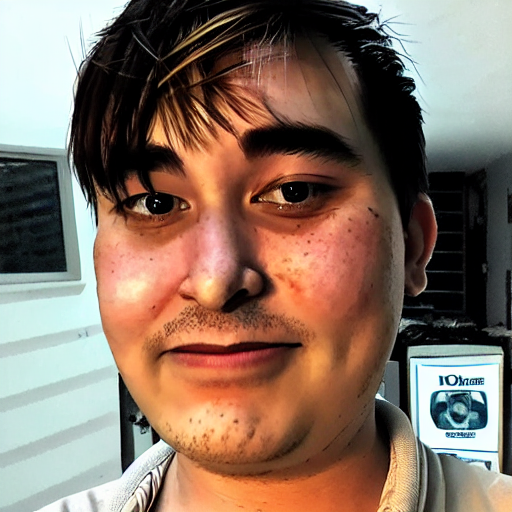

In [ ]:
# @title Inpainting with Age + Identity LoRA
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image


# Giảm RAM GPU (khuyến nghị cho Colab T4/A100)
pipe.enable_xformers_memory_efficient_attention()

# --- Ảnh đầu vào ---
image_path = "/content/drive/MyDrive/CV_PTIT/identity_lora_dataset/25.jpg"      # ảnh thật gốc
mask_path  = "/content/drive/MyDrive/CV_PTIT/identity_lora_dataset/mask.jpg"                 # mask vùng khuôn mặt (trắng = vùng chỉnh sửa)

image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("RGB")

prompt = "a portrait photo of a man, age 40s"

result = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask,
    guidance_scale=8.0,        # độ bám prompt
    num_inference_steps=40,    # bước khuếch tán
).images[0]


result.save("/content/personChung_age50s_inpainted.jpg")
result
